# Time series with seasonality

In this notebook, we'll take a look at some examples of time series with a clear seasonality.

I used data from the [time series data library](https://datamarket.com/data/list/?q=provider%3Atsdl) on Datamarket.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from helper import test_stationarity

%matplotlib inline

In [2]:
plt.style.use('bmh')
plt.rcParams['figure.figsize'] = [15,10]
plt.rcParams['font.size'] = 22

## Data set

I found this data set interesting in the time series library. It is made of 240 observations from 1920 to 1939. The values are monthly temperatures (Farenheit degrees) collected in the city of Nottingham. More details [here](https://datamarket.com/data/set/22li/mean-monthly-air-temperature-deg-f-nottingham-castle-1920-1939#!ds=22li&display=line).

In [3]:
mean_monthly_temp = pd.read_csv('mean-monthly-air-temperature-deg.csv', 
                              index_col=0,
                              parse_dates=True,
                              names=['Date', 'Temperature'],
                              header=0,
                              skipfooter=2, 
                              engine='python')
mean_monthly_temp.head()

,Temperature
Date,
1920-01-01,40.6
1920-02-01,40.8
1920-03-01,44.4
1920-04-01,46.7
1920-05-01,54.1


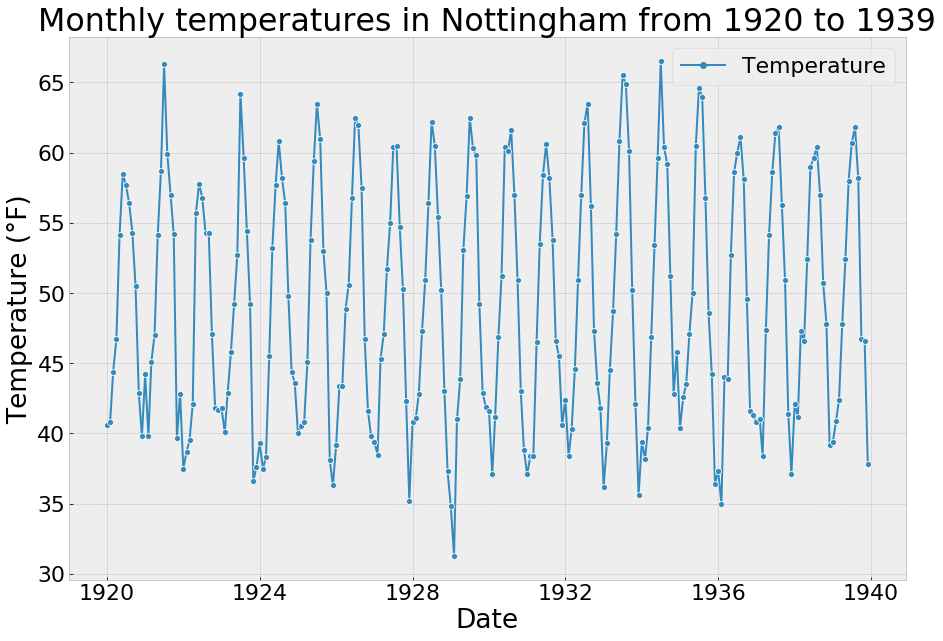

In [4]:
plt.ylabel('Temperature (°F)')
plt.xlabel('Time')
plt.title('Monthly temperatures in Nottingham from 1920 to 1939')
sns.lineplot(data = mean_monthly_temp, markers = True)

We immediately see the strong seasonality. Let's have a look at two or three years to zoom in a little bit.

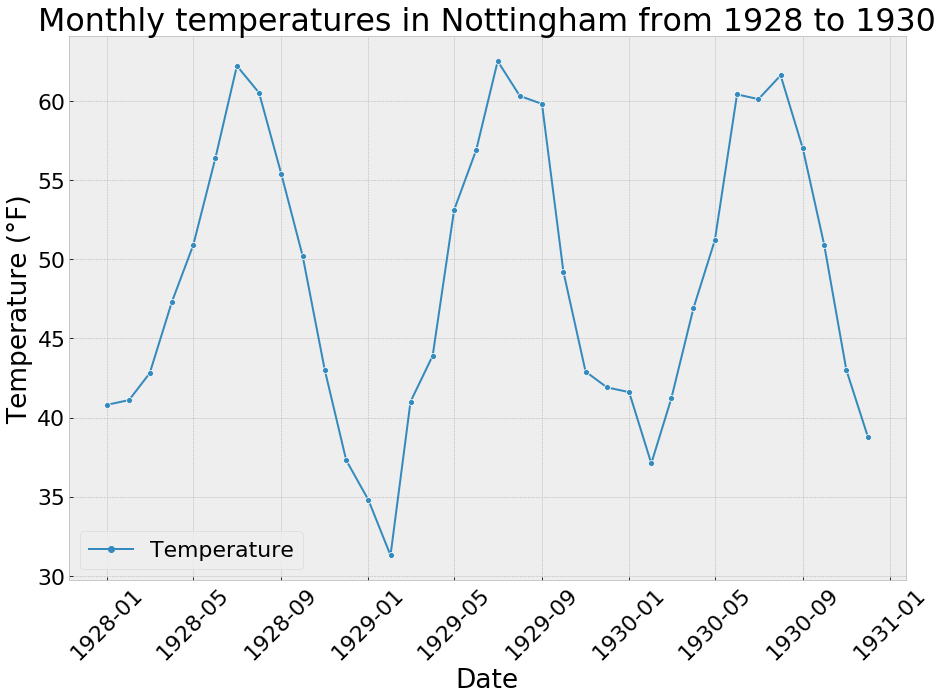

In [5]:
plt.ylabel('Temperature (°F)')
plt.xlabel('Time')
plt.xticks(rotation=45)
plt.title('Monthly temperatures in Nottingham from 1928 to 1930')
sns.lineplot(data = mean_monthly_temp['1928':'1930'], markers = True)

Of course the mean is lower during the Winter and greater during the Summer. No suprise here because we have this domain knowledge. We should see this monthly seasonality with a boxplot by month on the whole data set.

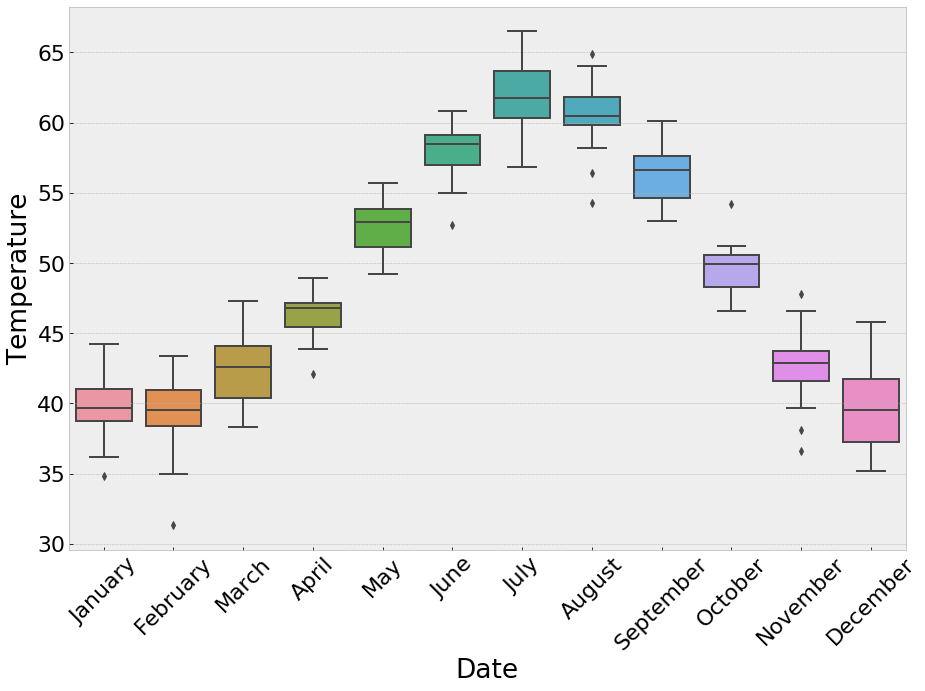

In [6]:
plt.xticks(rotation=45)
sns.boxplot(mean_monthly_temp.index.month_name(), mean_monthly_temp['Temperature'])

This boxplot is very instructive. We clearly see the monthly seasonality. July is the month with the highest median and December, January and February are the coldest months.

I think there is no clear trend. But to be sure we can use a convenient function from the statsmodel module.

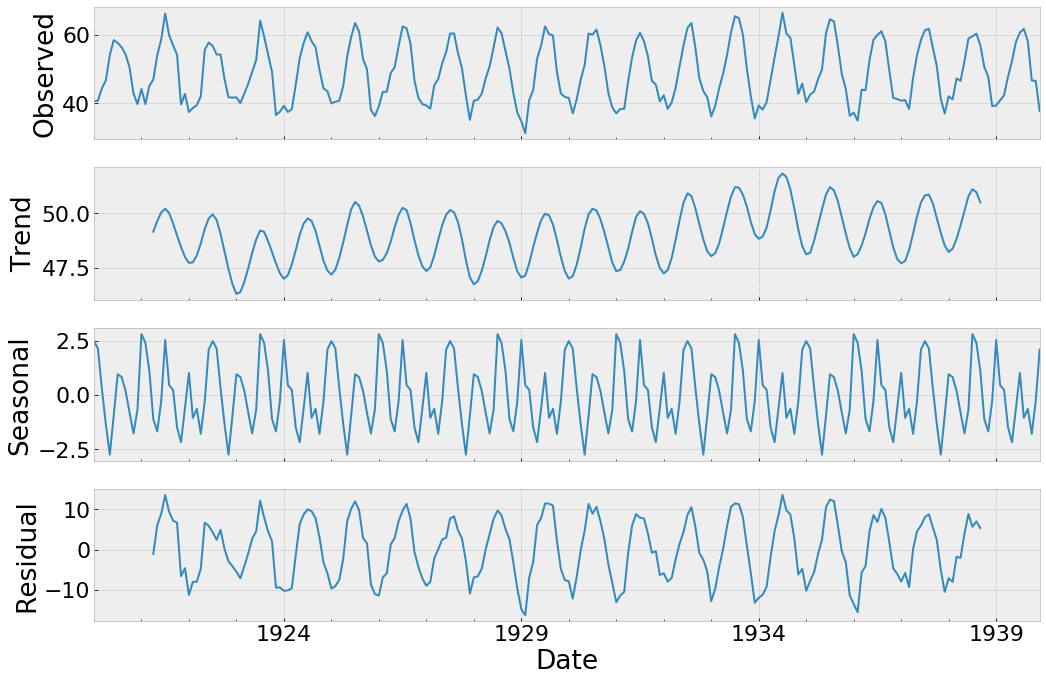

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
fig = seasonal_decompose(mean_monthly_temp, model='additive', freq=30).plot()

The seasonality is so strong that the trend evolves with the seasonality. We have what we call a stationary process. The rolling mean and variance are constant and the autocovariance does not depend on the time. We can verify by using the augmented Dickey-Fuller test. The implementation of the function is in a python module we created to use this function in several notebooks without having to copy/paste the same code each time we need to check for the stationarity of a process.

In [8]:
test_stationarity(mean_monthly_temp['Temperature'])

Test statistic: -3.255
p-value: 0.017
Number of lags used: 14
Critical value, 1 %: -3.460
Critical value, 5 %: -2.874


Please see the notebook time_series_forecasting for more info on the **Dickey-Fuller test**. From the values we got, we can conclude that the process is **stationary** with a **risk of 5 %**.

## Facebook prophet

### Context

**Facebook prophet** is a library available in **Python and R** dedicated to **time series forecasting**. As mentioned in the [original white paper](https://peerj.com/preprints/3190.pdf), this package is intended for analysts with **domain knowledge** but with no time series expertise. Indeed, time series forecasting is a hard task as it exists a large variety of different time series and techniques. There are only a few data scientists expert in this field and it is why Facebook open sourced Prophet, a framework that makes the life of data scientists/analysts easier. It provides **configurable models** and *anlyst-in-the-loop* **performance analysis**. It is espescially used for **supply-chain management**, **production** and **anomaly detection**.

Let's test it on our time series following the approach in the [quick start tutorial](https://facebook.github.io/prophet/docs/quick_start.html).

In [9]:
from fbprophet import Prophet

First we have to reformat our dataframe because Prophet expects a specific format.

In [10]:
mean_monthly_temp_prophet = mean_monthly_temp.reset_index()
mean_monthly_temp_prophet.columns = ['ds', 'y']
mean_monthly_temp_prophet.head()

,ds,y
0,1920-01-01,40.6
1,1920-02-01,40.8
2,1920-03-01,44.4
3,1920-04-01,46.7
4,1920-05-01,54.1


Then we can create the model. We leave the default parameters for now.

In [11]:
model = Prophet()
model.fit(mean_monthly_temp_prophet)

/anaconda3/envs/finance/lib/python3.6/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/anaconda3/envs/finance/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Predictions are made on a new dataframe. We can specify the number of predictions we want and the frequency. We have a value per month, I think we can predict the values of the next 6 months to get an idea.

In [18]:
future = model.make_future_dataframe(periods=6, freq='M')
predictions = model.predict(future)

In [19]:
predictions[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
241,1940-01-31,40.170690,37.309109,42.939194
242,1940-02-29,43.066030,40.352249,45.904184
243,1940-03-31,47.567471,44.781629,50.187174
244,1940-04-30,52.150199,49.360550,54.835690
245,1940-05-31,58.277546,55.327699,60.811934


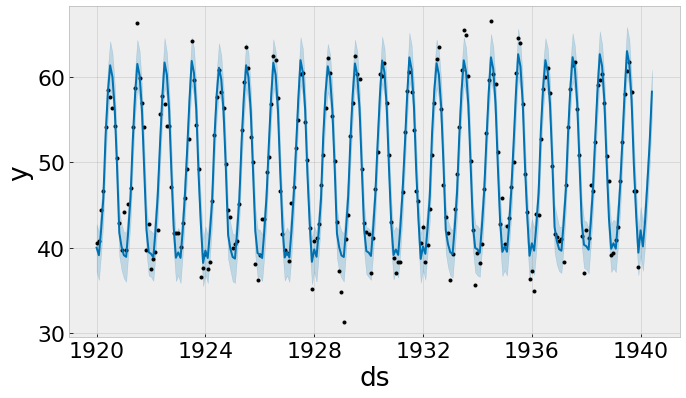

In [20]:
fig1 = model.plot(predictions)

Quite good for a quick start. We see that the model seems to fit well the previous data points and the predictions look good! But now we want a way to evaluate our model and have performance metrics.

### Evaluate a model with Facebook prophet

Work in progress ...